# Mini Project 4 - Reproducibility in Machine Learning


> - Study on the paper "TinyStories: How Small Can Language Models Be and Still Speak Coherent English?"
- reference: https://arxiv.org/abs/2305.07759



> Our project revisits a 2023 study on training smaller language models (SLMs) for proficient language
generation. The original work first presented the challenge of achieving fluency and coherence in text
generation, which are still characteristics mainly attributed to large-scale models. Then it posits that by
training the models on specialized text data stripped to its bare essentials, we can have much smaller models
(ones with only a few million parameters) to be as good or even better than "state-of-the-art models" for text
generation that is grammatically correct, diverse, and demonstrate decent reasoning capabilities [1]. Our
replication efforts indicated that while models trained on TinyStories showed commendable performance for
their size, they still lacked the precision and quality demonstrated in the original paper.





In [ ]:
!pip install -q -U accelerate
!pip install -q transformers
!pip install -q datasets
!pip install -q openai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.4/221.4 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
llmx 0.0.15a0 requires cohere, which is not installed.
llmx 0.0.15a0 requires tiktoken, which is not installed.


In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig, Trainer, TrainingArguments
import time
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset
import pandas as pd
import torch
import torch.nn.init as init
from openai import OpenAI
import re
import pandas as pd
from tqdm import tqdm

In [ ]:
client = OpenAI(api_key="")
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")

#0. Util Classes


> - Common functions for experiment convenience
- plotting and data preparation functions

For the Language Model Handling, to avoid the content repetition:


> - num_beams=1: This setting indicates we're not using beam search for diversification and are instead relying on a greedy approach that selects the most probable next word. This can lead to faster generation but may sometimes cause repetitive sequences.
- top_k=50: By using top-k sampling, we limit the choice for the next word to the top 50 candidates. This helps the model avoid very unlikely word choices and can reduce repetition by not over-focusing on a narrow set of high-probability words.
- top_p=0.95: This implements nucleus sampling, where we only consider the subset of words that make up the top 95% probability mass. It strikes a balance between diversity and fidelity, reducing the risk of generating repetitive or irrelevant content.





In [ ]:
def load_pretrained_model(model_name):
    model_full_name = f"roneneldan/{model_name}"
    model = AutoModelForCausalLM.from_pretrained(model_full_name)
    return model

def generate_text(model, tokenizer, prompt, max_length=100, num_beams=1, top_k=50, top_p=0.95, do_sample=True):
    # Encode the prompt to tensor of input IDs
    input_ids = tokenizer.encode(prompt, return_tensors='pt')

    # Check if the tokenizer has a pad token; if not, use EOS token
    pad_token_id = tokenizer.pad_token_id if tokenizer.pad_token_id is not None else tokenizer.eos_token_id

    # Compute the attention mask (1s for all input tokens)
    attention_mask = input_ids.ne(pad_token_id).int()

    # Start timing
    start_time = time.time()

    # Generate text with attention mask and pad token id set
    output = model.generate(input_ids,
                            max_length=max_length,
                            num_beams=num_beams,
                            attention_mask=attention_mask,
                            pad_token_id=pad_token_id,
                            top_k=top_k,
                            top_p=top_p,
                            do_sample=do_sample  # This enables sampling methods
                            )

    # End timing
    end_time = time.time()

    # Calculate time taken
    output_time = end_time - start_time

    # Print the output time
    print("Time taken (seconds):", output_time)

    generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

    # Post-process to ensure ending with a period
    if not generated_text.endswith(tuple('.!?')):
        generated_text = generated_text.rsplit('.', 1)[0] + '.'

    return generated_text

def print_model_outputs(models, tokenizer, prompt, max_length=100, num_beams=1, top_k=50, top_p=0.95, do_sample=True):
  for model_name, model in models.items():
    print(f"Using {model_name}: ")
    generated_text = generate_text(
        model=model,
        tokenizer=tokenizer,
        max_length=max_length,
        num_beams=num_beams,
        prompt=prompt,
        top_k=top_k,
        top_p=top_p,
        do_sample=do_sample  # This enables sampling methods
        )
    print_original_and_extended_text(prompt, generated_text)
    print("\n\n")

def print_original_and_extended_text(prompt, generated_text):
    # Print the original prompt
    print("Original Prompt:")
    print(prompt)

    # Extract the extended text (assuming the prompt is included in the generated text)
    extended_text = generated_text[len(prompt):]

    # Print the generated continuation
    print("\nExtended Text:")
    print(extended_text)


def plot_evaluation_metrics(models, metrics):
    # Define the models and their corresponding metric values
    model_names = models
    grammar_scores = metrics[:, 0]
    creativity_scores = metrics[:, 1]
    consistency_scores = metrics[:, 2]

    # Set the width of the bars
    bar_width = 0.2

    # Set the positions of the bars on the x-axis
    index = np.arange(len(model_names))

    # Create subplots for each metric
    fig, ax = plt.subplots(figsize=(10, 6))

    # Plot the bars for each metric
    ax.bar(index - bar_width, grammar_scores, bar_width, label='Grammar', align='center')
    ax.bar(index, creativity_scores, bar_width, label='Creativity', align='center')
    ax.bar(index + bar_width, consistency_scores, bar_width, label='Consistency', align='center')

    # Set the labels, title, and legend
    ax.set_xlabel('Models')
    ax.set_ylabel('Scores (out of 10)')
    ax.set_title('Evaluation Metrics for Different Prompts and Models')
    ax.set_xticks(index)
    ax.set_xticklabels(model_names)
    ax.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

def gpt3_output(prompt, max_tokens=10):
    completion = client.chat.completions.create(
        model="gpt-3.5-turbo",
        temperature=0,
        max_tokens=max_tokens,
        messages=[
            # {"role": "system", "content": "You are a poetic assistant, skilled in explaining complex programming concepts with creative flair."},
            {"role": "user", "content": prompt}
        ]
    )
    return completion.choices[0].message.content


def extract_integers(s):
    # Define the regex pattern for numbers 1-10
    pattern = r'\b(?:10|[1-9])\b'

    # Find all matches in the string
    matches = re.findall(pattern, s)

    # Return the first three matches, converting them to integers
    return [int(num) for num in matches[:3]]


def prompt_init(story_beginning, story_completion):
    temp1 = """The following exercise, the student is given a beginning of a story. The student needs to complete it into a full story.
    The exercise tests the the student´s language abilities and creativity. The symbol *** marks the separator between the
    prescribed beginning and the student’s completion:

    """
    temp2 = """

    Now, grade the student’s completion in terms of grammar, creativity, consistency with the story’s
    beginning. Each metric is ranging from 0 to 10. Please provide the information as an number array only,
    without additional explanation or text."""
    return temp1 + story_beginning + "***" + story_completion + temp2


def scores_from_llm(story_beginning, story_completion):
    prompt = prompt_init(story_beginning, story_completion)
    gpt_output = gpt3_output(prompt)
    scores_list = extract_integers(gpt_output)
    if len(scores_list) == 3:
        return np.array(scores_list)
    else:
        print("Scores_list error: ", gpt_output)
        return np.array([5, 5, 5])


def first_half_of_sentence(sentence):
    words = sentence.split()
    halfway_index = len(words) // 2
    return ' '.join(words[:halfway_index])


def sentences_test_builder(df):
    sentences_test = []
    for index, row in df.iterrows():
        sentences_test.append(first_half_of_sentence(str(row.text)))
    return sentences_test


def remove_prompt_part(prompt, output_text):
    prompt_words = prompt.split()
    output_text_words = output_text.split()[len(prompt_words):]
    return ' '.join(output_text_words)


def complete_text_with_prompt(model, tokenizer, prompt):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    output = model.generate(input_ids, max_length=1000, num_beams=1, temperature=1)
    output_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return output_text, model, tokenizer


def complete_text(model, tokenizer, prompt):
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.to(device)

    input_ids = tokenizer.encode(prompt, return_tensors="pt").to(device)
    output = model.generate(input_ids, max_length=1000, num_beams=1, temperature=1)
    output_text = tokenizer.decode(output[0], skip_special_tokens=True)
    return remove_prompt_part(prompt, output_text)

def complete_text_list(model, tokenizer, story_beginnings_list):
    output_strs = []
    for story_beginning in tqdm(story_beginnings_list):
        output_strs.append(complete_text(model, tokenizer, story_beginning))
    return output_strs

def complete_text_list_gpt3(story_beginnings_list):
    output_strs = []
    for story_beginning in tqdm(story_beginnings_list):
        # Use setting og 100 tokens which is similiar to the 33M TinyStories model
        completion_from_gpt3 = gpt3_output(story_beginning, 100)
        output_strs.append(completion_from_gpt3)
    return output_strs

def evaluate_score(model, tokenizer, story_beginnings_list):
    output_strs = []
    scores = []
    for story_beginning in tqdm(story_beginnings_list):
        # use completions_num = 1 because it's no different for TinyStories model
        output_str = complete_text(model, tokenizer, story_beginning, completions_num=1)[0]
        output_strs.append(output_str)
        score = scores_from_llm(story_beginnings_list[0], output_str)
        scores.append(score)
    scores = np.array(scores)
    avg_score = np.mean(scores, axis=0)
    return output_strs, scores, avg_score

def evaluate_score_from_completions(story_beginnings_list, output_strs):
    scores = []
    for idx, story_beginning in tqdm(enumerate(story_beginnings_list)):
        score = scores_from_llm(story_beginnings_list[0], output_strs[idx])
        scores.append(score)
    scores = np.array(scores)
    avg_score = np.mean(scores, axis=0)
    return scores, avg_score

def normalized_scores(arr):
    return (arr-np.min(arr, axis=0))/(np.max(arr, axis=0) - np.min(arr, axis=0))

def performance_df_builder(arr):
    row_labels = ['1M (64, 8)', '3M (128, 8)', '8M (126, 8)', '21M (1024, 1)', '28M (512, 8)', '33M (1024, 2)', '33M (768, 4)', 'GPT3.5']
    col_labels = ['Creativity', 'Grammar', 'Consistency']
    df = pd.DataFrame(arr, index=row_labels, columns=col_labels)
    return df

# 1. Reproduce the results


> - Objective: Reproduce findings of training small language models (SLMs) on TinyStories dataset.
- Dataset: Detail characteristics and size of TinyStories; discuss preprocessing if applied.
- Model Setup: Outline types of SLMs used, including architecture and parameters.
- Training Process: Describe training methodology, including epochs, learning rate, and other relevant details.
- Evaluation Framework: Implement GPT-4 based grading system as per paper.
- Results Comparison: Compare replicated results with original paper's findings.
Challenges & Solutions: Discuss any encountered obstacles and how they were resolved.



## 1.1 Model Preparation


> - Environment Configuration
- Import the models and settings would be tested in the experiments



### Import the Baseline Models



> - GPT2-XL (1.5B parameters)





In [ ]:
# Initialize the baseline tokenizer
baseline_tokenizer = AutoTokenizer.from_pretrained("gpt2-xl")

# Load the baseline model
gpt2_xl_model = AutoModelForCausalLM.from_pretrained("gpt2-xl")

In [ ]:
# Sample prompt
prompt = "Once upon a time in a faraway land,"

# Generate text with a specific model (e.g., GPT-2 XL)
generated_text_gpt2_xl = generate_text(model=gpt2_xl_model, tokenizer=baseline_tokenizer, prompt=prompt)
print("GPT-2 XL Generated Text:", generated_text_gpt2_xl)

Time taken (seconds): 55.86678695678711
GPT-2 XL Generated Text: Once upon a time in a faraway land, there was a man who had a dream. He dreamed that he was a king, and that he had a beautiful wife. He dreamed that he had a beautiful castle, and that he had a beautiful daughter. He dreamed that he had a beautiful castle, and that he had a beautiful daughter. He dreamed that he had a beautiful castle, and that he had a beautiful daughter.


In [ ]:
# view the model structure
gpt2_xl_model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1600)
    (wpe): Embedding(1024, 1600)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-47): 48 x GPT2Block(
        (ln_1): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1600,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1600, out_features=50257, bias=False)
)

### Import the Pretrained Small Language Models


> - SLM (33M)
- SLM (3M)
- SLM (1M)
- SLM (8M)
- SLM (28M)
- SLM with 1 transformer block (21M)
- SLM with 2 transformer blocks (33M)



In [ ]:
# Define the SLM models involved in the experiments
model_names = ["TinyStories-33M", "TinyStories-3M", "TinyStories-1M", "TinyStories-8M", "TinyStories-28M", "TinyStories-1Layer-21M", "TinyStories-2Layers-33M"]
models = {}

# Initialize the SLM tokenizer (Based on GPT Neo)
slm_tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M")

# Load pretrained SLM model
for model_name in model_names:
    models[model_name] = load_pretrained_model(model_name)

tokenizer_config.json:   0%|          | 0.00/560 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/357 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/968 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/291M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/66.7M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/48.6M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/112M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/242M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/323M [00:00<?, ?B/s]

In [ ]:
# Example prompt
prompt = "Once upon a time in a faraway land,"

# Generate text with a specific model (e.g., GPT-2 XL)
generated_text_slm = generate_text(model=models["TinyStories-33M"], tokenizer=slm_tokenizer, prompt=prompt)
print("SLM Generated Text:", generated_text_gpt2_xl)

Time taken (seconds): 2.4088449478149414
SLM Generated Text: Once upon a time in a faraway land, there was a man who had a dream. He dreamed that he was a king, and that he had a beautiful wife. He dreamed that he had a beautiful castle, and that he had a beautiful daughter. He dreamed that he had a beautiful castle, and that he had a beautiful daughter. He dreamed that he had a beautiful castle, and that he had a beautiful daughter.


In [ ]:
# View the Model Structure
models["TinyStories-33M"]

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-3): 4 x GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_feat

## 1.2 Dataset Preperation

In [ ]:
# Use 1-51 rows from val set to evaluate models
df_val = pd.DataFrame(load_dataset("roneneldan/TinyStories", split="validation[:100]"))
story_beginnings_list = sentences_test_builder(df_val[1:51])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


In [ ]:
story_beginnings_list[0:2]

['Once upon a time, in a big forest, there lived a rhinoceros named Roxy. Roxy loved to climb. She climbed trees, rocks, and hills. One day, Roxy found an icy hill. She had never seen anything like it before. It was shiny and cold, and she wanted to climb it. Roxy tried to climb the icy hill, but it was very slippery. She tried again and again, but she kept falling down. Roxy was sad. She wanted to climb the icy hill so much. Then, she saw a little bird named Billy. Billy saw that Roxy was sad and asked, "Why are you sad, Roxy?" Roxy told Billy about the icy hill and how she couldn\'t climb',
 'Once upon a time, in a small yard, there was a small daisy. The daisy had a name. Her name was Daisy. Daisy was very small, but she was also very happy. One day, Daisy saw a dog. The dog was big and had a name too. His name was Max. Max']

Follow the same method from original paper. Using 50 stories from validation dataset and keep the first half as input prompts. We choose the 2nd stories until the 51th one to reach a better generalization because they share the same beginning "Once upon a time...".

## 1.3 Evaluation method (GPT-Eval)

In [ ]:
def complete_text_list(model, tokenizer, story_beginnings_list):
    output_strs = []
    for story_beginning in tqdm(story_beginnings_list):
        output_strs.append(complete_text(model, tokenizer, story_beginning, 1)[0])
    return output_strs

def evaluate_score_from_completions(story_beginnings_list, output_strs):
    scores = []
    for idx, story_beginning in tqdm(enumerate(story_beginnings_list)):
        score = scores_from_llm(story_beginnings_list[0], output_strs[idx])
        scores.append(score)
    scores = np.array(scores)
    avg_score = np.mean(scores, axis=0)
    return scores, avg_score

During the evaluation, we had the model complete a story for each prompt and used GPT-3.5 to obtain average scores for 50 prompts. We observed identical completions from the Tinystories models using the same prompts, so the additional 9 completions mentioned in the original paper were no longer necessary. Due to a limited budget for evaluation with commercial GPT, we made several modifications from the original paper. We used GPT-3.5 for evaluation instead of GPT-4. We also compared the Tinystories models with GPT-3.5 instead of GPT-4. And we only completed each prompt once, as opposed to generating 10 completions as in the original paper.Similar to the original paper, we used a temperature one across all models in the performance comparison.

## 1.4. Peformance comparison among models

### 1.4.1 Implementation

In [ ]:
model_1M = AutoModelForCausalLM.from_pretrained('roneneldan/TinyStories-1M')
print(model_1M)

config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/48.6M [00:00<?, ?B/s]

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 64)
    (wpe): Embedding(2048, 64)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-7): 8 x GPTNeoBlock(
        (ln_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=64, out_features=64, bias=False)
            (v_proj): Linear(in_features=64, out_features=64, bias=False)
            (q_proj): Linear(in_features=64, out_features=64, bias=False)
            (out_proj): Linear(in_features=64, out_features=64, bias=True)
          )
        )
        (ln_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=64, out_features=256, bias=True)
          (c_proj): Linear(in_features=256, out_

In [ ]:
output_strs_1M, scores_1M, avg_score_1M = evaluate_score(model_1M, tokenizer, story_beginnings_list)

In [ ]:
avg_score_1M

array([6.9 , 7.66, 6.7 ])

In [ ]:
model_3M = AutoModelForCausalLM.from_pretrained('roneneldan/TinyStories-3M')
print(model_3M)

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 128)
    (wpe): Embedding(2048, 128)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-7): 8 x GPTNeoBlock(
        (ln_1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=128, out_features=128, bias=False)
            (v_proj): Linear(in_features=128, out_features=128, bias=False)
            (q_proj): Linear(in_features=128, out_features=128, bias=False)
            (out_proj): Linear(in_features=128, out_features=128, bias=True)
          )
        )
        (ln_2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=128, out_features=512, bias=True)
          (c_proj): Linear(in_featu

In [ ]:
output_strs_3M, scores_3M, avg_score_3M = evaluate_score(model_3M, tokenizer, story_beginnings_list)

In [ ]:
avg_score_3M

array([7.54, 7.82, 7.74])

In [ ]:
model_8M = AutoModelForCausalLM.from_pretrained('roneneldan/TinyStories-8M')
print(model_8M)

config.json:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/112M [00:00<?, ?B/s]

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 256)
    (wpe): Embedding(2048, 256)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-7): 8 x GPTNeoBlock(
        (ln_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=256, out_features=256, bias=False)
            (v_proj): Linear(in_features=256, out_features=256, bias=False)
            (q_proj): Linear(in_features=256, out_features=256, bias=False)
            (out_proj): Linear(in_features=256, out_features=256, bias=True)
          )
        )
        (ln_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=256, out_features=1024, bias=True)
          (c_proj): Linear(in_feat

In [ ]:
output_strs_8M, scores_8M, avg_score_8M = evaluate_score(model_8M, tokenizer, story_beginnings_list)

In [ ]:
avg_score_8M

array([7.78, 8.02, 7.92])

In [ ]:
model_21M = AutoModelForCausalLM.from_pretrained('roneneldan/TinyStories-1Layer-21M')
print(model_21M)

config.json:   0%|          | 0.00/1.05k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/269M [00:00<?, ?B/s]

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(2048, 1024)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0): GPTNeoBlock(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
          (c_proj): Linear(

In [ ]:
output_strs_21M = complete_text_list(model_21M, tokenizer, story_beginnings_list)

In [ ]:
scores_21M, avg_score_21M = evaluate_score_from_completions(output_strs_21M, story_beginnings_list)

50it [01:05,  1.30s/it]


In [ ]:
avg_score_21M

array([8.  , 7.52, 8.46])

In [ ]:
model_28M = AutoModelForCausalLM.from_pretrained('roneneldan/TinyStories-28M')
print(model_28M)

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 512)
    (wpe): Embedding(2048, 512)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-7): 8 x GPTNeoBlock(
        (ln_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=512, out_features=512, bias=False)
            (v_proj): Linear(in_features=512, out_features=512, bias=False)
            (q_proj): Linear(in_features=512, out_features=512, bias=False)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
        )
        (ln_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=512, out_features=2048, bias=True)
          (c_proj): Linear(in_feat

In [ ]:
output_strs_28M = complete_text_list(model_28M, tokenizer, story_beginnings_list)

In [ ]:
scores_28M, avg_score_28M = evaluate_score_from_completions(output_strs_28M, story_beginnings_list)

50it [01:08,  1.36s/it]


In [ ]:
avg_score_28M

array([8. , 7.4, 8.1])

In [ ]:
model_33M_2 = AutoModelForCausalLM.from_pretrained('roneneldan/TinyStories-2Layers-33M')
print(model_33M_2)

config.json:   0%|          | 0.00/1.08k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/323M [00:00<?, ?B/s]

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 1024)
    (wpe): Embedding(2048, 1024)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-1): 2 x GPTNeoBlock(
        (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=False)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
        )
        (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
          (c_proj): L

In [ ]:
output_strs_33M_2 = complete_text_list(model_33M_2, tokenizer, story_beginnings_list)

In [ ]:
scores_33M_2, avg_score_33M_2 = evaluate_score_from_completions(output_strs_33M_2, story_beginnings_list)
avg_score_33M_2

50it [01:13,  1.48s/it]


array([8.  , 7.96, 8.8 ])

In [ ]:
model_33M = AutoModelForCausalLM.from_pretrained('roneneldan/TinyStories-33M')

In [ ]:
output_strs_33M, scores_33M, avg_score_33M = evaluate_score(model_33M, tokenizer, story_beginnings_list)

In [ ]:
avg_score_33M

array([7.68, 8.08, 8.  ])

In [ ]:
output_strs_gpt3 = complete_text_list_gpt3(story_beginnings_list)

100%|██████████| 50/50 [06:44<00:00,  8.08s/it]


In [ ]:
scores_gpt3, avg_score_gpt3 = evaluate_score_from_completions(output_strs_gpt3, story_beginnings_list)
avg_score_gpt3

50it [01:11,  1.43s/it]


array([8.  , 8.44, 8.56])

### 1.4.2 Results

In [ ]:
scores_arr = np.array([[6.9 , 7.66, 6.7 ], [7.54, 7.82, 7.74], [7.78, 8.02, 7.92], [8.  , 7.52, 8.46], [8. , 7.4, 8.1], [8.  , 7.96, 8.8 ],[7.68, 8.08, 8.  ],[8.  , 8.44, 8.56]])

In [ ]:
scores_arr_n = normalized_scores(scores_arr)

In [ ]:
scores_df = performance_df_builder(scores_arr)
print(scores_df)

,Creativity,Grammar,Consistency
"1M (64, 8)",6.90,7.66,6.70
"3M (128, 8)",7.54,7.82,7.74
"8M (126, 8)",7.78,8.02,7.92
"21M (1024, 1)",8.00,7.52,8.46
"28M (512, 8)",8.00,7.40,8.10
"33M (1024, 2)",8.00,7.96,8.80
"33M (768, 4)",7.68,8.08,8.00
GPT3.5,8.00,8.44,8.56


In [ ]:
scores_df_normalized = performance_df_builder(scores_arr_n)
scores_df_normalized

,Creativity,Grammar,Consistency
"1M (64, 8)",0.000000,0.250000,0.000000
"3M (128, 8)",0.581818,0.403846,0.495238
"8M (126, 8)",0.800000,0.596154,0.580952
"21M (1024, 1)",1.000000,0.115385,0.838095
"28M (512, 8)",1.000000,0.000000,0.666667
"33M (1024, 2)",1.000000,0.538462,1.000000
"33M (768, 4)",0.709091,0.653846,0.619048
GPT3.5,1.000000,1.000000,0.885714


Generally, larger models perform better across the three scores. Compared to GPT-3.5 with 175 billion parameters, much smaller models achieve comparable performance in terms of generating hundreds of words in stories. From the figure, we can see that all four models with more than 20 million parameters are very close to GPT-3.5 in creativity and consistency scores. However, GPT-3.5 slightly outperforms them in grammar scores, which may indicate that these models need a more complex structure to correct small grammatical errors.

Format: model_name (Hidden size, Layer).

## 1.5 Analyze with Example Prompt



> - Demonstrating model outputs using specific prompts or examples, providing a direct insight into model behavior and capabilities.
- Firstly, we examine the model completion and performance with the three example prompt stated in the paper
- Secondly, we investigate the model ability to deal with factual prompts, reasoning prompts, and context-tracking prompts



### 1.5.1 Completion of different models with scores


> - Test the model performance with different types of prompts such as different story type
- Evaluate the generated output from different language models by manual GPT4 evaluation


**The Prompt from GPT-Eval**


In the following exercise, the student is given a beginning of a story. The student needs to complete it into a full story. The exercise tests the student's language abilities and creativity. The symbol ^^^ marks the separator between the prescribed beginning and the student’s completion:

[Original Sentence] ^^^ [Extended Sentences]

Now, grade the student’s completion in terms of grammar, creativity, and consistency with the story’s beginning. Each metric is ranging from 0 to 10. Please provide the information as a number array only, without additional explanation or text.





#### Example Prompt 1


> Once upon a time there was a little girl named Lucy. She was very adventurous. She loved to explore the world around her, especially when it was bright and sunny outside.
One day, while exploring the nearby park, Lucy came across a ladder leaning on a wall. She was curious to see what’s on top, so she climbed the ladder, but when she reached the top, the ladder fell and she was stuck.
A nearby park ranger noticed her and shouted out, ”




**Evaluation in term of Grammar, Creativity, Consistency with the story beginning. Each Metric is ranging from 0 to 10:**

**With the array format [Grammar, Creativity, Consistency]**



- Baseline [Grammar: 7/10, Creativity: 5/10, Consistency: 3/10]

- TinyStories-33M [Grammar: 9/10, Creativity: 6/10, Consistency: 8/10]

- TinyStories-3M [Grammar: 5/10, Creativity: 7/10, Consistency: 4/10]

- TinyStories-1M [Grammar: 3/10, Creativity: 4/10, Consistency: 2/10]

- TinyStories-8M [Grammar: 8/10, Creativity: 7/10, Consistency: 6/10]

- TinyStories-28M [Grammar: 9/10, Creativity: 6/10, Consistency: 7/10]

- TinyStories-1Layer-21M [Grammar: 4/10, Creativity: 5/10, Consistency: 3/10]

- TinyStories-2Layers-33M [Grammar: 8/10, Creativity: 7/10, Consistency: 7/10]







In [ ]:
prompt_1 = """Once upon a time there was a little girl named Lucy. She was very adventurous. She loved to explore the world around her, especially when it was bright and sunny outside. One day, while exploring the nearby park, Lucy came across a ladder leaning on a wall. She was curious to see what’s on top, so she climbed the ladder, but when she reached the top, the ladder fell and she was stuck. A nearby park ranger noticed her and shouted out, ”"""

In [ ]:
# Baseline Model
print("The Baseline Model Generated Text:")
generated_text_gpt2_xl = generate_text(
    model=gpt2_xl_model,
    tokenizer=baseline_tokenizer,
    max_length=200,
    num_beams=1,
    top_k=50,
    top_p=0.95,
    do_sample=True,
    prompt=prompt_1
    )

print_original_and_extended_text(prompt_1, generated_text_gpt2_xl)

The Baseline Model Generated Text:
Time taken (seconds): 77.19766783714294
Original Prompt:
Once upon a time there was a little girl named Lucy. She was very adventurous. She loved to explore the world around her, especially when it was bright and sunny outside. One day, while exploring the nearby park, Lucy came across a ladder leaning on a wall. She was curious to see what’s on top, so she climbed the ladder, but when she reached the top, the ladder fell and she was stuck. A nearby park ranger noticed her and shouted out, ”

Extended Text:
Help! Help! Someone's trapped on this ladder!"

Lucy and her family were very happy when the ranger went to help, and he told them that the ladder was stuck because Lucy had pulled a long, narrow, and difficult to undo handle with her teeth. Since then, every girl Lucy encountered has made sure that the people they meet are made aware of the existence of the handle.

The handle was invented by the late Harry E.


In [ ]:
# SLM Models
print_model_outputs(
    models=models,
    tokenizer=slm_tokenizer,
    max_length=200,
    num_beams=1,
    top_k=50,
    top_p=0.95,
    do_sample=True,
    prompt=prompt_1
)

Using TinyStories-33M: 
Time taken (seconds): 3.501793384552002
Original Prompt:
Once upon a time there was a little girl named Lucy. She was very adventurous. She loved to explore the world around her, especially when it was bright and sunny outside. One day, while exploring the nearby park, Lucy came across a ladder leaning on a wall. She was curious to see what’s on top, so she climbed the ladder, but when she reached the top, the ladder fell and she was stuck. A nearby park ranger noticed her and shouted out, ”

Extended Text:
I’m here to help you get down from the ladder!” Lucy was really scared, but she knew she had to be brave. She closed her eyes and counted to three, and together they were able to climb down the ladder safely.



Using TinyStories-3M: 
Time taken (seconds): 1.8478074073791504
Original Prompt:
Once upon a time there was a little girl named Lucy. She was very adventurous. She loved to explore the world around her, especially when it was bright and sunny outside.

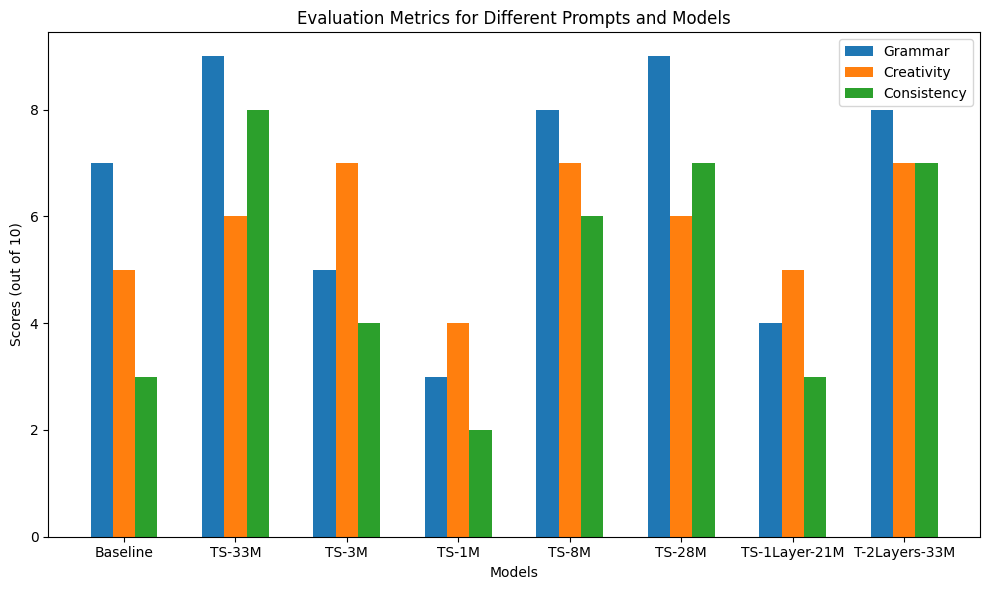

In [ ]:
models = ['Baseline', 'TS-33M', 'TS-3M', 'TS-1M', 'TS-8M', 'TS-28M', 'TS-1Layer-21M', 'T-2Layers-33M']
metrics = np.array([[7, 5, 3], [9, 6, 8], [5, 7, 4], [3, 4, 2], [8, 7, 6], [9, 6, 7], [4, 5, 3], [8, 7, 7]])

plot_evaluation_metrics(models, metrics)

#### Example Prompt 2


> Once upon a time there was a pumpkin. It was a very special pumpkin, it could speak. It was sad because it couldn’t move. Every day, it would say

**Evaluation in term of Grammar, Creativity, Consistency with the story beginning. Each Metric is ranging from 0 to 10:**

**With the array format [Grammar, Creativity, Consistency]**



- Baseline [Grammar: 7/10, Creativity: 8/10, Consistency: 5/10]

- TinyStories-33M [Grammar: 8/10, Creativity: 7/10, Consistency: 6/10]

- TinyStories-3M [Grammar: 5/10, Creativity: 7/10, Consistency: 4/10]

- TinyStories-1M [Grammar: 4/10, Creativity: 6/10, Consistency: 3/10]

- TinyStories-8M [Grammar: 8/10, Creativity: 7/10, Consistency: 6/10]

- TinyStories-28M [Grammar: 8/10, Creativity: 7/10, Consistency: 5/10]

- TinyStories-1Layer-21M [Grammar: 6/10, Creativity: 6/10, Consistency: 4/10]

- TinyStories-2Layers-33M [Grammar: 8/10, Creativity: 7/10, Consistency: 6/10]


In [ ]:
prompt_2 = """Once upon a time there was a pumpkin. It was a very special pumpkin, it could speak. It was sad because it couldn’t move. Every day, it would say"""

In [ ]:
# Baseline Model
print("The Baseline Model Generated Text:")
generated_text_gpt2_xl = generate_text(
    model=gpt2_xl_model,
    tokenizer=baseline_tokenizer,
    max_length=200,
    num_beams=1,
    top_k=50,
    top_p=0.95,
    do_sample=True,
    prompt=prompt_2
    )
print_original_and_extended_text(prompt_2, generated_text_gpt2_xl)

The Baseline Model Generated Text:
Time taken (seconds): 100.88402080535889
Original Prompt:
Once upon a time there was a pumpkin. It was a very special pumpkin, it could speak. It was sad because it couldn’t move. Every day, it would say

Extended Text:
 things like, ’we can come out’ and it would be gone in a week. Well, some people thought it was a figment of their imaginations. Others, it was true. The people who saw the pumpkin spoke of it with reverence. They said it was a spirit. They called it Pumpkin, the spirit of the pumpkin. It could travel to people if its skin was removed. Some believe that in the event of a scarecrow dying in their yard, the spirit of the scarecrow will travel to them and take over. It may have taken over the ghost of a man who was killed on his farm but there are others who say that when it is removed from the spirit house, it can no longer exist.


In [ ]:
# SLM Models
print_model_outputs(
    models=models,
    tokenizer=slm_tokenizer,
    max_length=200,
    num_beams=1,
    top_k=50,
    top_p=0.95,
    do_sample=True,
    prompt=prompt_2,
)



Using TinyStories-33M: 
Time taken (seconds): 4.9844970703125
Original Prompt:
Once upon a time there was a pumpkin. It was a very special pumpkin, it could speak. It was sad because it couldn’t move. Every day, it would say

Extended Text:
 a little Hello and smile at everyone.

One day, the pumpkin heard a funny noise. He looked around and saw that a rabbit had been hopping by. It was laughing and saying "What are you doing?"

The pumpkin said “I'm sorry! I was scared. I didn’t know what to do!”

The rabbit said “It’s okay, I understand. You can speak. Just don’t be scared!”

The pumpkin smiled, happy to hear that. He thanked the rabbit and said goodbye. From then on, the pumpkin was never scared again. He would always talk to people and make them happy.



Using TinyStories-3M: 
Time taken (seconds): 1.523763656616211
Original Prompt:
Once upon a time there was a pumpkin. It was a very special pumpkin, it could speak. It was sad because it couldn’t move. Every day, it would say

Ext

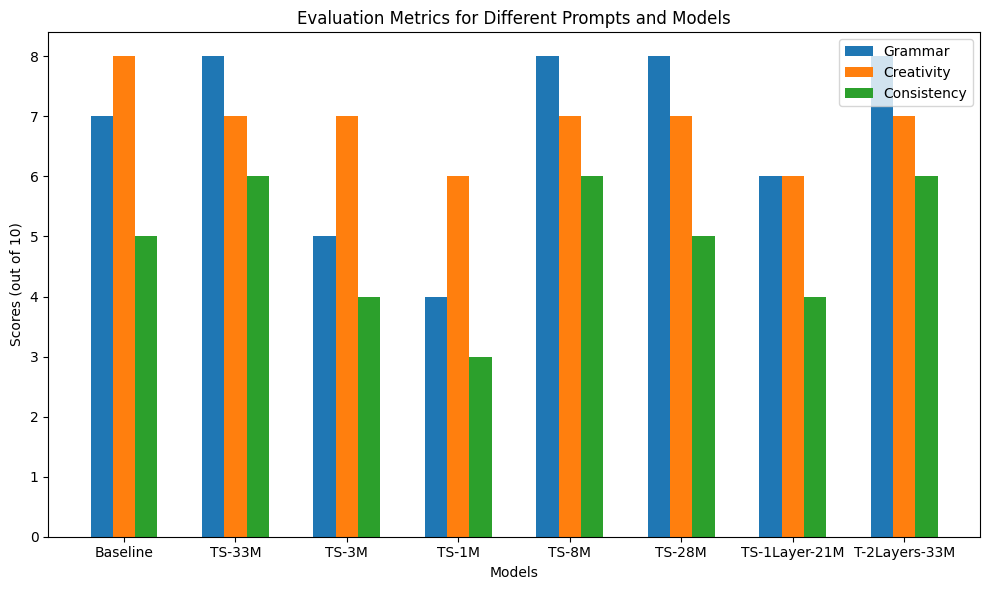

In [ ]:
# Example usage for Prompt 2:
models2 = ['Baseline', 'TS-33M', 'TS-3M', 'TS-1M', 'TS-8M', 'TS-28M', 'TS-1Layer-21M', 'T-2Layers-33M']
metrics2 = np.array([[7, 8, 5], [8, 7, 6], [5, 7, 4], [4, 6, 3], [8, 7, 6], [8, 7, 5], [6, 6, 4], [8, 7, 6]])

plot_evaluation_metrics(models2, metrics2)


#### Example Prompt 3



> Once upon a time, there lived a black cat. The cat belonged to a little girl called Katie. Every day, Katie would take her cat for a walk in the park.
One day, as Katie and her cat were walking around, they saw a mean looking man. He said he wanted to take the cat, to which she replied ”This cat belongs

**Evaluation in term of Grammar, Creativity, Consistency with the story beginning. Each Metric is ranging from 0 to 10:**

**With the array format [Grammar, Creativity, Consistency]**



- Baseline [Grammar: 6/10, Creativity: 5/10, Consistency: 2/10]

- TinyStories-33M [Grammar: 7/10, Creativity: 6/10, Consistency: 5/10]

- TinyStories-3M [Grammar: 6/10, Creativity: 5/10, Consistency: 4/10]

- TinyStories-1M [Grammar: 4/10, Creativity: 5/10, Consistency: 3/10]

- TinyStories-8M [Grammar: 6/10, Creativity: 5/10, Consistency: 6/10]

- TinyStories-28M [Grammar: 7/10, Creativity: 6/10, Consistency: 8/10]

- TinyStories-1Layer-21M [Grammar: 6/10, Creativity: 5/10, Consistency: 6/10]

- TinyStories-2Layers-33M [Grammar: 4/10, Creativity: 3/10, Consistency: 5/10]


In [ ]:
prompt_3 = """Once upon a time, there lived a black cat. The cat belonged to a little girl called Katie. Every day, Katie would take her cat for a walk in the park. One day, as Katie and her cat were walking around, they saw a mean looking man. He said he wanted to take the cat, to which she replied ”This cat belongs"""

In [ ]:
# Baseline Model
print("The Baseline Model Generated Text:")
generated_text_gpt2_xl = generate_text(
    model=gpt2_xl_model,
    tokenizer=baseline_tokenizer,
    max_length=200,
    num_beams=1,
    top_k=50,
    top_p=0.95,
    do_sample=True,
    prompt=prompt_3
    )
print_original_and_extended_text(prompt_3, generated_text_gpt2_xl)

The Baseline Model Generated Text:
Time taken (seconds): 78.19567322731018
Original Prompt:
Once upon a time, there lived a black cat. The cat belonged to a little girl called Katie. Every day, Katie would take her cat for a walk in the park. One day, as Katie and her cat were walking around, they saw a mean looking man. He said he wanted to take the cat, to which she replied ”This cat belongs

Extended Text:
 to me, I own her. You don't own me, you didn't get the gold mine, this is your money, you don't get anything but what I give you!” Katie's cat didn't seem to care for this guy very much. The cat growled at the man and walked away, but Katie kept running after the cat.

She couldn't leave her cat behind, for Katie's mother was dead. Her father died of a heart attack. Katie's mother was murdered in her own home, with the man who wanted to take her cat by her throat.


In [ ]:
# SLM Models
print_model_outputs(
    models=models,
    tokenizer=slm_tokenizer,
    max_length=200,
    num_beams=1,
    top_k=50,
    top_p=0.95,
    do_sample=True,
    prompt=prompt_3,
)

Using TinyStories-33M: 
Time taken (seconds): 4.21358847618103
Original Prompt:
Once upon a time, there lived a black cat. The cat belonged to a little girl called Katie. Every day, Katie would take her cat for a walk in the park. One day, as Katie and her cat were walking around, they saw a mean looking man. He said he wanted to take the cat, to which she replied ”This cat belongs

Extended Text:
 with me!” The man was very angry and tried to grab the cat. Katie did not want to go so deep into the woods and said “No, this cat is mine and I will not let him take it away.” But the mean man was too strong and took the cat away. Katie cried and looked for her cat all around the park but she couldn't find her.

She was so sad that she had to leave the park and go home without her cat. The bad man did not let her take his cat ever again.



Using TinyStories-3M: 
Time taken (seconds): 0.9553709030151367
Original Prompt:
Once upon a time, there lived a black cat. The cat belonged to a little

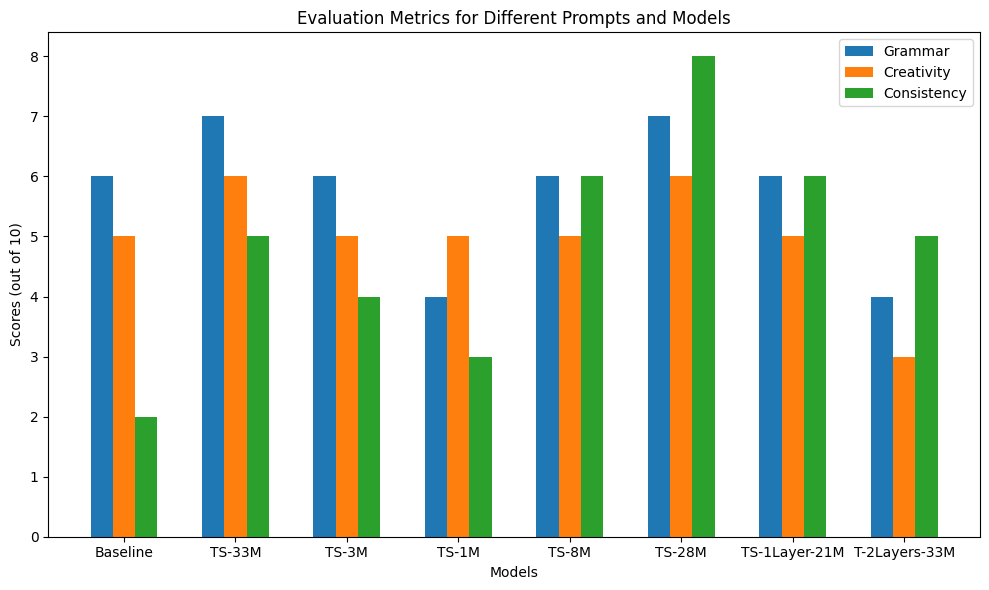

In [ ]:
# Example usage for Prompt 3:
models3 = ['Baseline', 'TS-33M', 'TS-3M', 'TS-1M', 'TS-8M', 'TS-28M', 'TS-1Layer-21M', 'T-2Layers-33M']
metrics3 = np.array([[6, 5, 2], [7, 6, 5], [6, 5, 4], [4, 5, 3], [6, 5, 6], [7, 6, 8], [6, 5, 6], [4, 3, 5]])

plot_evaluation_metrics(models3, metrics3)


#### Some Interesting Findings

- **Performance of Smaller Models:** TS-33M and TS-28M, despite having significantly fewer parameters compared to GPT-2 with 1.5B parameters, exhibit surprising performance. They often perform on par with or even better than GPT-2 in terms of generating coherent text.

- **Consistency:** TS-33M and TS-28M demonstrate consistent performance across different prompts, indicating their stability and reliability in generating text.

- **Effect of Transformer Layers:** TS-33M, which uses four transformer layers, outperforms TS-2Layers-33M, which has only two layers. This suggests that increasing the number of layers can improve the model's ability to provide coherent sentences.

- **Performance of Smaller Models:** Smaller models like TS-1M and TS-3M, which have fewer parameters, tend to perform relatively poorly in generating text, indicating the importance of model size in text generation tasks.

- **Surprising Performance of TS-8M:** TS-8M, despite its modest 8M parameters, performs reasonably well in generating coherent sentences. This suggests that even smaller models can provide acceptable text generation capabilities.

- **Computational Efficiency:** GPT-2 requires significantly more time for usage compared to the smaller language models, which can be a crucial consideration in real-time applications.

### 1.5.2 Performance of different models on factual prompts

- Our goal here is to re-create the short - medium length generations originally seen in Figure 9,10,11 tables of the study. We get our desired length responses by altering the max_length of generation for the three themed-prompts
- Problems encountered:
- max_length that happen to be too short lead to non-sensical text generated and even blank generations at times (context.csv highlights that very well, completely nonsensical under max_length = 70)
- Changing around top_k and top_p we have (since the study did mention zero temperature multiple times here and there), we have blunted creativity/diversity but more coherent responses
- That is to say, high top_k and top_p values tend to ramble (as illustrated in factual_creative.csv for e.g.)
- top_k = 1 and top_p = 0 to try to emulate the zero temperature default in the original study. We see from factual.csv that responses are a lot more streamlined when top_k and top_p are low, which confirms our previous conjecture.

In [ ]:
# Add gpt-2XL to the models
models['GPT2XL'] = gpt2_xl_model

In [ ]:
def run_themed_prompts(input_prompts):
    # Create an empty DataFrame
    columns = ['Prompt'] + list(models.keys())
    results_df = pd.DataFrame(columns=columns)

    # Iterate through each prompt and model, storing the results
    for idx, prompt in enumerate(input_prompts):
        results = {'Prompt': prompt[str(idx+1)]}
        for model_name, model in models.items():
            generated_text = generate_text(model, tokenizer, prompt[str(idx+1)], max_length = 70, top_k = 1, top_p = 0)
            generated_text = re.sub('\n', ' ', generated_text)  # Remove newlines from generated text
            results[model_name] = re.sub(re.escape(prompt[str(idx+1)]), '', generated_text) # Remove the prompt itself from the text generated, account for weird escape characters in text
        results_df = results_df.append(results, ignore_index=True)
    return results_df

In [ ]:
# Load prompts from context.json
with open('context.json', 'r') as file:
    data = json.load(file)
factual_prompts = data['factual']  # Adjust this according to the structure of your JSON file
contextual_prompts = data['context']
reasoning_prompts = data['reasoning']

factual_generation = run_themed_prompts(factual_prompts)
# factual_generation.to_csv('factual.csv', index=False)  # Optionally save to CSV


### 1.5.3 Performance of different models on reasoning prompts

In [ ]:
reasoning_generation = run_themed_prompts(reasoning_prompts)
# reasoning_generation.to_csv('reasoning.csv', index=False)  # Optionally save to CSV

### 1.5.4 Performance of different models on context-tracking prompts



In [ ]:
contextual_generation = run_themed_prompts(contextual_prompts)
# contextual_generation.to_csv('context.csv', index=False)  # Optionally save to CSV

### 1.6 Interpretability Anlalysis



> The attention heads exhibit diverse and meaningful functions, such as attending to the previous word, the subject of the sentence, the end of the sentence, or the main topic of the story.


In [ ]:
prompt = "One day, Lucy asks Tom: ”I am looking for a banana but I can’t find it”. Tom says: ”Don’t "

analyze_text, model, tokenizer = complete_text_with_prompt(
    model=models["TinyStories-33M"],
    tokenizer=slm_tokenizer,
    prompt=prompt
  )

print(analyze_text)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


One day, Lucy asks Tom: ”I am looking for a banana but I can’t find it”. Tom says: ”Don’t listen, Lucy. I know where the banana is.”

So, Tom and Lucy set off on an adventure to find the banana. They searched high and low, but they couldn’t find it.

Finally, they came across a big tree. Under the tree was a big banana! Lucy was so happy. She said: “Thank you, Tom! You are so kind.”

Tom smiled and said: “You’re welcome, Lucy. I’m glad I could help.”



In [ ]:
text = """
One day, Lucy asks Tom: ”I am looking for a banana but I can’t find it”. Tom says: ”Don’t listen, Lucy. I know where the banana is.”

So, Tom and Lucy set off on an adventure to find the banana. They searched high and low, but they couldn’t find it.

Finally, they came across a big tree. Under the tree was a big banana! Lucy was so happy. She said: “Thank you, Tom! You are so kind.”

Tom smiled and said: “You’re welcome, Lucy. I’m glad I could help.”
"""

In [ ]:
# Load tokenizer and model
tokenizer = slm_tokenizer
model = models["TinyStories-33M"]
model.config.output_attentions = True  # Ensure attentions are returned
model.eval()  # Set the model to evaluation mode

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-3): 4 x GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_feat

In [ ]:
inputs = tokenizer(text, return_tensors="pt")

In [ ]:
outputs = model(**inputs)
attentions = outputs.attentions  # This will be a tuple of length `num_layers`, each with shape [batch_size, num_heads, sequence_length, sequence_length]

In [ ]:
# Extract the attention weights for the first layer
layer_attentions = attentions[0]  # Assuming you want the first layer

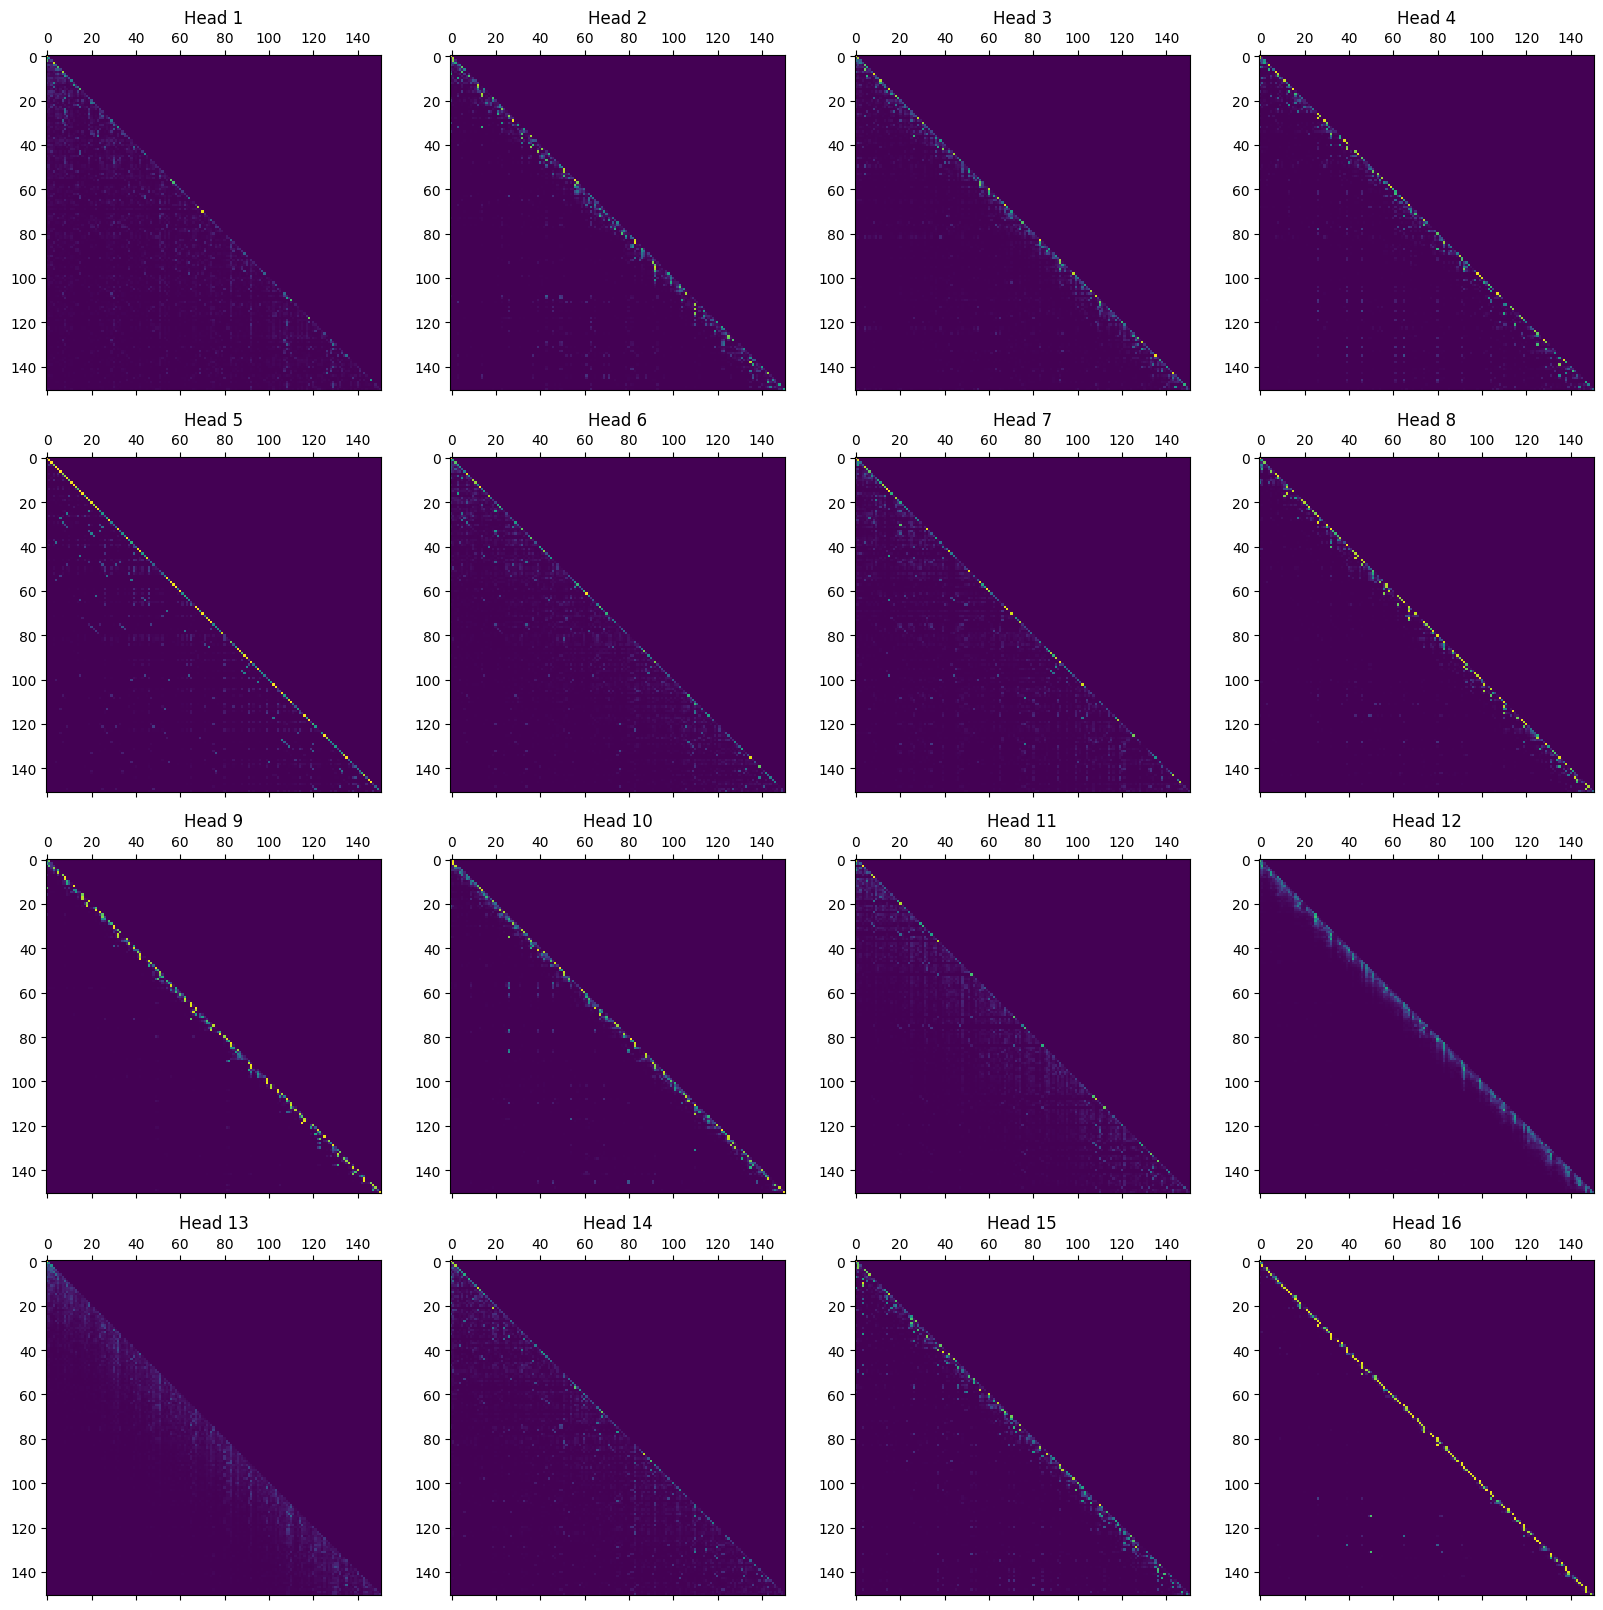

In [ ]:
import matplotlib.pyplot as plt

# Let's plot the attention for each head
num_heads = layer_attentions.size(1)
fig, axes = plt.subplots(4, 4, figsize=(20, 20))  # Adjust the grid size based on the number of heads

for i, ax in enumerate(axes.flatten()):
    # We take the first example in the batch and the attention from head `i`
    attention_head = layer_attentions[0, i].detach().numpy()
    ax.matshow(attention_head, cmap='viridis')
    ax.set_title(f'Head {i+1}')

plt.show()


#### Some Interesting Findings:

- Diagonal Patterns: Many of the attention heads show strong diagonal patterns. This indicates that tokens are largely attending to themselves and their immediate neighbors. This is expected in language models, as nearby tokens are often most relevant for predicting the next word in a sequence.

- Variability Among Heads: Each head has a distinct pattern, which suggests that different heads are specializing in different types of attention. For instance, some heads might be capturing syntactic relationships, while others might focus on longer-range semantic relationships.

- Off-Diagonal Attention: Some heads display off-diagonal bright spots, indicating that the model is considering tokens that are not adjacent. This could mean that the model is capturing longer-distance dependencies in the text, such as relationships between subjects and objects or between verbs and their arguments.

# 2. Ablation Studies

In [ ]:
# N/A

# 3. Hyperparameter tunning

## 3.1 Different dropout rate inside the transformer block

### 3.1.1 Implementation

In [ ]:
dataset_train = load_dataset("roneneldan/TinyStories", split="validation[10000:20000]")
# To speed up training, ignore the validation dataset
dataset_val = load_dataset("roneneldan/TinyStories", split="validation[20000:]")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


In [ ]:
len(dataset_train), len(dataset_val)

(10000, 1990)

In [ ]:
tokenizer.pad_token = tokenizer.eos_token
def tokenize_function(examples):
    # GPT-Neo architecture with window size 256 and context length 512
    tokenized_output = tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)
    # GPT-Neo expects labels for language modeling
    tokenized_output["labels"] = tokenized_output["input_ids"].copy()
    return tokenized_output


tokenized_dataset_train = dataset_train.map(tokenize_function, batched=True)
tokenized_dataset_val = dataset_val.map(tokenize_function, batched=True)

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1990 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset_train, tokenized_dataset_val

(Dataset({
     features: ['text', 'input_ids', 'attention_mask', 'labels'],
     num_rows: 10000
 }),
 Dataset({
     features: ['text', 'input_ids', 'attention_mask', 'labels'],
     num_rows: 1990
 }))

In [ ]:
model_1M = AutoModelForCausalLM.from_pretrained('roneneldan/TinyStories-1M')
print(model_1M)

config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/48.6M [00:00<?, ?B/s]

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 64)
    (wpe): Embedding(2048, 64)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-7): 8 x GPTNeoBlock(
        (ln_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=64, out_features=64, bias=False)
            (v_proj): Linear(in_features=64, out_features=64, bias=False)
            (q_proj): Linear(in_features=64, out_features=64, bias=False)
            (out_proj): Linear(in_features=64, out_features=64, bias=True)
          )
        )
        (ln_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=64, out_features=256, bias=True)
          (c_proj): Linear(in_features=256, out_

In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=4,
    num_train_epochs=1,
    logging_dir='./logs',
    logging_steps=10,
    # evaluation_strategy="steps",  # Evaluate at the end of each logging_steps
)

In [ ]:
# Use different drop out rate for attention layers
dropout_percentages = [0.3, 0.5, 0.7]
models_diff_drop_out_rate = {}
for p in dropout_percentages:
    print("For attention layers, use drop out rate: ", p)

    model = AutoModelForCausalLM.from_pretrained('roneneldan/TinyStories-1M').to("cuda")

    for block in model.transformer.h:
        # Adjust attention dropout
        block.attn.attention.attn_dropout.p = p
        block.attn.attention.resid_dropout.p = p
    print(model)

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_dataset_train,
        # eval_dataset=tokenized_dataset_val
    )
    trainer.train()
    models_diff_drop_out_rate[p] = model

For attention layers, use drop out rate:  0.3
GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 64)
    (wpe): Embedding(2048, 64)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-7): 8 x GPTNeoBlock(
        (ln_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.3, inplace=False)
            (resid_dropout): Dropout(p=0.3, inplace=False)
            (k_proj): Linear(in_features=64, out_features=64, bias=False)
            (v_proj): Linear(in_features=64, out_features=64, bias=False)
            (q_proj): Linear(in_features=64, out_features=64, bias=False)
            (out_proj): Linear(in_features=64, out_features=64, bias=True)
          )
        )
        (ln_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=64, out_features=256, bias=True)
  

Step,Training Loss
10,4.708400
20,3.035700
30,2.575300
40,1.855200
50,2.203600
60,1.943200
70,2.025000
80,1.960000
90,1.848800
100,2.096900


For attention layers, use drop out rate:  0.5
GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 64)
    (wpe): Embedding(2048, 64)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-7): 8 x GPTNeoBlock(
        (ln_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.5, inplace=False)
            (resid_dropout): Dropout(p=0.5, inplace=False)
            (k_proj): Linear(in_features=64, out_features=64, bias=False)
            (v_proj): Linear(in_features=64, out_features=64, bias=False)
            (q_proj): Linear(in_features=64, out_features=64, bias=False)
            (out_proj): Linear(in_features=64, out_features=64, bias=True)
          )
        )
        (ln_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=64, out_features=256, bias=True)
  

Step,Training Loss
10,5.630600
20,3.848900
30,3.296700
40,2.292800
50,2.663600
60,2.291600
70,2.325400
80,2.241200
90,2.108400
100,2.358700


For attention layers, use drop out rate:  0.7
GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 64)
    (wpe): Embedding(2048, 64)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0-7): 8 x GPTNeoBlock(
        (ln_1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.7, inplace=False)
            (resid_dropout): Dropout(p=0.7, inplace=False)
            (k_proj): Linear(in_features=64, out_features=64, bias=False)
            (v_proj): Linear(in_features=64, out_features=64, bias=False)
            (q_proj): Linear(in_features=64, out_features=64, bias=False)
            (out_proj): Linear(in_features=64, out_features=64, bias=True)
          )
        )
        (ln_2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=64, out_features=256, bias=True)
  

Step,Training Loss
10,7.392500
20,4.822700
30,4.245900
40,3.113500
50,3.656300
60,3.099500
70,3.018300
80,2.849600
90,2.630700
100,2.854500


In [ ]:
models_diff_drop_out_rate[0.3]

In [ ]:
output_strs_dropout3 = complete_text_list(models_diff_drop_out_rate[0.3], tokenizer, story_beginnings_list)

In [ ]:
output_strs_dropout3[0]

'the bird was. The bird was so happy that he said, "Yes, you can help me, I have to be careful. I will be careful. I will be careful." Mmm, Ben and the bird was so happy. He said, "Thank you, I\'m glad you. You\'re welcome, you, I\'m sorry, I\'m sorry, I\'m glad you, you. I\'m sorry." Ravi smiled and said, "Thank you, "I love you, I love you, I\'m sorry, I\'m sorry, I\'m sorry. I\'m sorry to the bird. You are you, I will be careful. I\'m sorry." Sara and said, "Thank you can\'t worry, Ben. You\'re welcome, I\'m glad you, I\'m sorry, I\'m sorry. We will be careful. We are the bird. We can you for you. You can you help you, I will be careful. You are you. You can help me. You can help you. You can play with the best. You can be your friends. I will help me." Sara and the tree was happy. He said, "I love you, you. I love you. He is a good. I love you, and a good friends. You can be more fun. You are very good. You are very happy. You are friends. You are good friends. Sara and they are ha

### 3.2.1 Result

In [ ]:
scores_1M_d3, avg_score_1M_d3 = evaluate_score_from_completions(output_strs_dropout3, story_beginnings_list)
avg_score_1M_d3

50it [00:57,  1.14s/it]


array([6.82, 7.32, 5.6 ])

In [ ]:
output_strs_dropout5 = complete_text_list(models_diff_drop_out_rate[dropout_percentages[1]], tokenizer, story_beginnings_list)

In [ ]:
scores_1M_d5, avg_score_1M_d5 = evaluate_score_from_completions(output_strs_dropout5, story_beginnings_list)
avg_score_1M_d5

50it [00:59,  1.20s/it]


array([5.48, 6.8 , 5.54])

In [ ]:
output_strs_dropout7 = complete_text_list(models_diff_drop_out_rate[dropout_percentages[2]], tokenizer, story_beginnings_list)

In [ ]:
scores_1M_d7, avg_score_1M_d7 = evaluate_score_from_completions(output_strs_dropout7, story_beginnings_list)
avg_score_1M_d7

50it [00:56,  1.13s/it]


array([6.12, 6.22, 6.6 ])

1. Rate 0.3: [6.82, 7.32, 5.6 ]
2. Rate 0.5: [5.48, 6.8 , 5.54]
3. Rate 0.7: [6.12, 6.22, 6.6 ]

A higher dropout rate negatively impacts performance. One possible explanation is that the dropout strategy combats overfitting, yet the model has not yet overfitted. According to the original paper, the evaluation loss consistently decreases after thousands of training steps, suggesting that two million training data points are insufficient to cause overfitting in the model. Furthermore, after altering the dropout rates, we trained the model on a manually constructed validation dataset, which does not overlap with the stories from the training set. Assuming the model is trained for one epoch or less, a common practice for large language models, overfitting is unlikely given the diversity of the synthetic story dataset. Therefore, it is reasonable to observe a decrease in performance when applying the dropout strategy to a model that has not overfitted.

# 4. Training GPT-neo from zero

## 4.1 Implementation

In [ ]:
local_drive = "/content/drive/MyDrive/"
prompt = """Once upon a time, in a big forest, there lived a rhinoceros named Roxy. Roxy loved to climb. She climbed trees, rocks, and hills. One day, Roxy found an icy hill. She had never seen anything like it before. It was shiny and cold, and she wanted to climb it. Roxy tried to climb the icy hill, but it was very slippery. She tried again and again, but she kept falling down. Roxy was sad. She wanted to climb the icy hill so much. Then, she saw a little bird named Billy. Billy saw that Roxy was sad and asked, "Why are you sad, Roxy?" Roxy told Billy about the icy hill and how she couldn't climb"""

In [ ]:
tokenized_dataset_train_from_zero = load_dataset('parquet', data_files=local_drive+"tokenized_dataset.parquet")

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
tokenized_dataset_train_from_zero = tokenized_dataset_train_from_zero["train"]

In [ ]:
tokenized_dataset_train_from_zero

Dataset({
    features: ['text', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 2119719
})

In [ ]:
model_from_zero = AutoModelForCausalLM.from_pretrained(local_drive + "results/checkpoint-85000")

### 4.1.1 Tokenize dataset

In [ ]:
dataset_train_from_zero = load_dataset("roneneldan/TinyStories", split="train")
dataset_train_from_zero

/usr/local/lib/python3.10/dist-packages/huggingface_hub/repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


Dataset({
    features: ['text'],
    num_rows: 2119719
})

In [ ]:
tokenizer.pad_token = tokenizer.eos_token
def tokenize_function(examples):
    # GPT-Neo architecture with window size 256 and context length 512
    tokenized_output = tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)
    # GPT-Neo expects labels for language modeling
    tokenized_output["labels"] = tokenized_output["input_ids"].copy()
    return tokenized_output

tokenized_dataset_train_from_zero = dataset_train_from_zero.map(tokenize_function, batched=True)
tokenized_dataset_train_from_zero

Map:   0%|          | 0/2119719 [00:00<?, ? examples/s]

Dataset({
    features: ['text', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 2119719
})

In [ ]:
# Save the tokenized dataset as a Parquet file
tokenized_dataset_train_from_zero.to_parquet(local_drive + "tokenized_dataset.parquet")

Creating parquet from Arrow format:   0%|          | 0/2120 [00:00<?, ?ba/s]

16045706775

### 4.1.2 Training

In [ ]:
from transformers import AutoConfig, AutoModelForCausalLM

In [ ]:
config = AutoConfig.from_pretrained('roneneldan/TinyStories-1M')
model_from_zero = AutoModelForCausalLM.from_config(config).to("cuda")

In [ ]:
result = complete_text(model_from_zero, tokenizer, prompt)
result

In [ ]:
training_args = TrainingArguments(
    output_dir=local_drive + "results",
    per_device_train_batch_size=8,
    num_train_epochs=1,
    logging_dir=local_drive + "logs",
    logging_steps=10,
    save_total_limit=1,
    # load_best_model_at_end = True
)

trainer = Trainer(
    model=model_from_zero,
    args=training_args,
    train_dataset=tokenized_dataset_train_from_zero.select(range(1000*1000)),
)

trainer.train(resume_from_checkpoint=True)

There were missing keys in the checkpoint model loaded: ['lm_head.weight'].


Step,Training Loss
85010,1.297800
85020,1.193600
85030,1.303600
85040,1.269500
85050,1.140700
85060,1.277000
85070,1.306800
85080,1.159500
85090,1.198900
85100,1.240100


TrainOutput(global_step=125000, training_loss=0.3968451748504639, metrics={'train_runtime': 6671.0634, 'train_samples_per_second': 149.901, 'train_steps_per_second': 18.738, 'total_flos': 1224081408000000.0, 'train_loss': 0.3968451748504639, 'epoch': 1.0})

In [ ]:
trainer.state.log_history

[{'epoch': 0.0,
  'learning_rate': 4.999600000000001e-05,
  'loss': 10.5888,
  'step': 10},
 {'epoch': 0.0, 'learning_rate': 4.9992e-05, 'loss': 10.1461, 'step': 20},
 {'epoch': 0.0, 'learning_rate': 4.9988e-05, 'loss': 9.8683, 'step': 30},
 {'epoch': 0.0, 'learning_rate': 4.9984e-05, 'loss': 9.6963, 'step': 40},
 {'epoch': 0.0,
  'learning_rate': 4.9980000000000006e-05,
  'loss': 9.4659,
  'step': 50},
 {'epoch': 0.0,
  'learning_rate': 4.9976000000000004e-05,
  'loss': 9.2519,
  'step': 60},
 {'epoch': 0.0, 'learning_rate': 4.9972e-05, 'loss': 9.0584, 'step': 70},
 {'epoch': 0.0,
  'learning_rate': 4.996800000000001e-05,
  'loss': 8.8644,
  'step': 80},
 {'epoch': 0.0, 'learning_rate': 4.9964e-05, 'loss': 8.7268, 'step': 90},
 {'epoch': 0.0, 'learning_rate': 4.996e-05, 'loss': 8.5177, 'step': 100},
 {'epoch': 0.0, 'learning_rate': 4.9956e-05, 'loss': 8.3045, 'step': 110},
 {'epoch': 0.0,
  'learning_rate': 4.9952000000000006e-05,
  'loss': 8.0547,
  'step': 120},
 {'epoch': 0.0,
  'l

### 4.1.3 Testing on one example

In [ ]:
result = complete_text(model_from_zero, tokenizer, prompt)
result

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'the water. The bird said, "I\'m sorry, I\'m sorry. I\'m sorry to you. I\'m sorry to help you. I\'ll help you." The little girl was so happy and said, "I\'m sorry, but I\'m sorry. I will be kind and I will be kind." And they were happy and they were happy.'

## 4.2 Result

In [ ]:
tokenized_dataset_train_from_zero

Dataset({
    features: ['text', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 2119719
})

In [ ]:
len(trainer.state.log_history)

12501

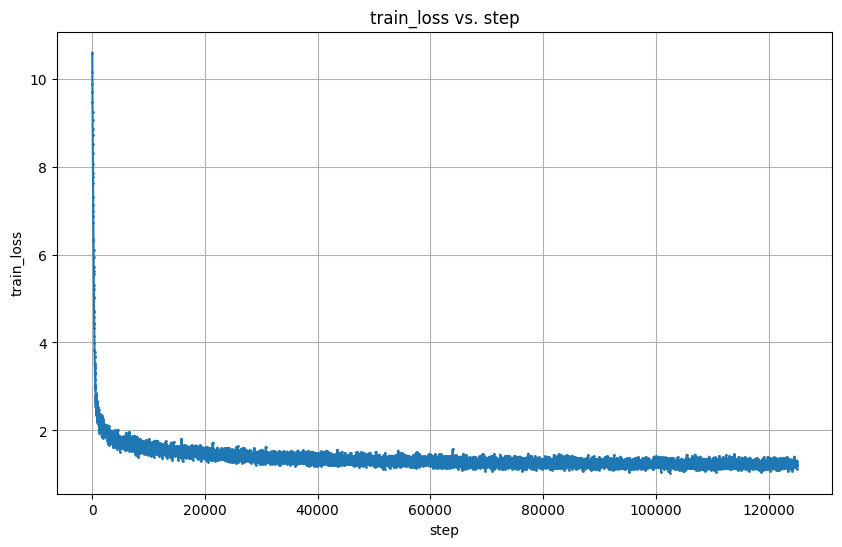

In [ ]:
import matplotlib.pyplot as plt

data = trainer.state.log_history[0:12500]

steps = [item['step'] for item in data]
losses = [item['loss'] for item in data]

plt.figure(figsize=(10, 6))
plt.plot(steps, losses, marker='o', markersize=1)
plt.title("train_loss vs. step")
plt.xlabel("step")
plt.ylabel("train_loss")
plt.grid(True)
plt.show()

Trained the model with one million parameters (removed pretrained weights) on the original paper's training dataset (2,119,719 stories). Used eight data points per step and only trained for one epoch. The original paper is not well-written in the training section because it does not provide explanations about the label setting using the training dataset. Given the nature of the autoregression model, we assume this model based on gpt-neo architecture also predicts the next word based on the one before it. Thus, we set labels equal to inputs during the tokenization process, enabling the model to use the word following the current word as labels. Similar to the original paper, we observed that the training loss reduces slowly after thousands of training steps. Although the orginal paper does not explain how many data points are in one step, the trend in our image is similiar to their.